In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
     

Data Gathering


In [3]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv

df = pd.read_csv("Sunspots.csv", index_col=0)
df.head()

--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

 (81.4 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



Date  Monthly Mean Total Sunspot Number
0  1749-01-31                               96.7
1  1749-02-28                              104.3
2  1749-03-31                              116.7
3  1749-04-30                               92.8
4  1749-05-31                              141.7

Preprocess and batch data

<Figure size 360x432 with 0 Axes>

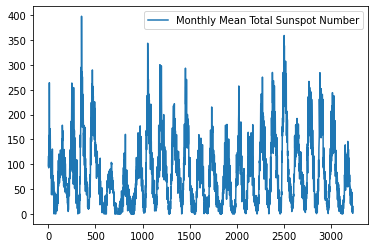

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = df["Monthly Mean Total Sunspot Number"].values.reshape(-1, 1)
data = scaler.fit_transform(data)
     

fig = plt.figure(figsize=(5, 6));
df.plot();

Multi-output forecasting vs. single step model

Predict multiple next values at once.

In [5]:
BUFFER_SIZE = 1024
WINDOW_SIZE = 60

samples = tf.data.Dataset.from_tensor_slices(data)
samples = samples.window(size=WINDOW_SIZE + 1, shift=1, drop_remainder=True).flat_map(lambda w : w.batch(WINDOW_SIZE + 1))
samples = samples.map(lambda x : (tf.expand_dims(x[:-1], axis=-1), x[1:]))
samples = samples.shuffle(BUFFER_SIZE)
     

In [6]:
BATCH_SIZE = 64

test_size = 0.2
num_samples = sum(1 for x in samples)
num_train_samples = int((1 - test_size) * num_samples)
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_samples - num_train_samples)
ds_train = samples.take(num_train_samples).batch(BATCH_SIZE)
ds_val = samples.skip(num_train_samples).batch(BATCH_SIZE)

Number of training samples: 2540
Number of validation samples: 635


Model

Stacked RNN

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Conv1D, LSTM, Dense, GRU
     

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[WINDOW_SIZE, 1]))
model.add(GRU(128, return_sequences=True))
model.add(GRU(64, return_sequences=True))
model.add(Dense(32, activation="swish"))
model.add(Dense(16, activation="swish"))
model.add(Dense(1))
     

model.compile(optimizer="rmsprop", loss="huber", metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 32)            192       
                                                                 
 gru (GRU)                   (None, 60, 128)           62208     
                                                                 
 gru_1 (GRU)                 (None, 60, 64)            37248     
                                                                 
 dense (Dense)               (None, 60, 32)            2080      
                                                                 
 dense_1 (Dense)             (None, 60, 16)            528       
                                                                 
 dense_2 (Dense)             (None, 60, 1)             17        
                                                                 
Total params: 102,273
Trainable params: 102,273
Non-trai

In [9]:
model.fit(ds_train, epochs=10, validation_data=ds_val);


Epoch 1/10
40/40 [==============================] - 8s 195ms/step - loss: 0.0024 - mae: 0.0496 - val_loss: 0.0021 - val_mae: 0.0478
Epoch 2/10
40/40 [==============================] - 9s 230ms/step - loss: 0.0023 - mae: 0.0488 - val_loss: 0.0019 - val_mae: 0.0441
Epoch 3/10
40/40 [==============================] - 8s 197ms/step - loss: 0.0023 - mae: 0.0488 - val_loss: 0.0023 - val_mae: 0.0505
Epoch 4/10
40/40 [==============================] - 9s 228ms/step - loss: 0.0022 - mae: 0.0481 - val_loss: 0.0020 - val_mae: 0.0469
Epoch 5/10
40/40 [==============================] - 8s 195ms/step - loss: 0.0023 - mae: 0.0482 - val_loss: 0.0025 - val_mae: 0.0525
Epoch 6/10
40/40 [==============================] - 8s 196ms/step - loss: 0.0022 - mae: 0.0482 - val_loss: 0.0021 - val_mae: 0.0479
Epoch 7/10
40/40 [==============================] - 8s 195ms/step - loss: 0.0022 - mae: 0.0480 - val_loss: 0.0021 - val_mae: 0.0482
Epoch 8/10
40/40 [==============================] - 8s 198ms/step - loss: 0.

Bidirectional RNN

In [10]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[WINDOW_SIZE, 1]))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Dense(32, activation="swish"))
model.add(Dense(16, activation="swish"))
model.add(Dense(1))

model.compile(optimizer="rmsprop", loss="huber", metrics=["mae"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 60, 32)            192       
                                                                 
 bidirectional (Bidirectiona  (None, 60, 128)          37632     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 128)          74496     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 60, 32)            4128      
                                                                 
 dense_4 (Dense)             (None, 60, 16)            528       
                                                                 
 dense_5 (Dense)             (None, 60, 1)            

In [12]:
model.fit(ds_train, epochs=10, validation_data=ds_val);


Epoch 1/10
40/40 [==============================] - 12s 288ms/step - loss: 0.0022 - mae: 0.0472 - val_loss: 0.0039 - val_mae: 0.0652
Epoch 2/10
40/40 [==============================] - 9s 230ms/step - loss: 0.0017 - mae: 0.0412 - val_loss: 0.0014 - val_mae: 0.0375
Epoch 3/10
40/40 [==============================] - 9s 229ms/step - loss: 0.0014 - mae: 0.0382 - val_loss: 0.0012 - val_mae: 0.0336
Epoch 4/10
40/40 [==============================] - 9s 231ms/step - loss: 0.0011 - mae: 0.0337 - val_loss: 5.6733e-04 - val_mae: 0.0231
Epoch 5/10
40/40 [==============================] - 9s 230ms/step - loss: 8.2575e-04 - mae: 0.0295 - val_loss: 3.4004e-04 - val_mae: 0.0176
Epoch 6/10
40/40 [==============================] - 9s 229ms/step - loss: 6.0937e-04 - mae: 0.0256 - val_loss: 4.2137e-04 - val_mae: 0.0227
Epoch 7/10
40/40 [==============================] - 9s 230ms/step - loss: 5.1597e-04 - mae: 0.0230 - val_loss: 2.2536e-04 - val_mae: 0.0161
Epoch 8/10
40/40 [=============================